<a href="https://colab.research.google.com/github/emolinaperez/econometrics_mek/blob/main/Week%202/R/Week2_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Econometrics

load library for importing database into R (from stata format)


In [1]:
library(foreign)
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




load data

In [2]:
jobcorpsfile<-"https://raw.githubusercontent.com/emolinaperez/econometrics_mek/main/Week%202/data/jobcorps.dta"
JobCorps<-read.dta(jobcorpsfile, convert.dates = TRUE, convert.factors = TRUE,missing.type = FALSE,convert.underscore = FALSE, warn.missing.labels = TRUE)


explore file

In [3]:
head(JobCorps)

,earnq1,earnq2,earnq3,earnq4,earnq5,earnq6,earnq7,earnq8,earnq9,earnq10,⋯,arrest_bline,jail_bline,participate,voc_in_jc,work_wk48,pct_wks_wrk,logwage_wk208,wagenotmiss,attrit,nomiss
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.00000,0.0,0.00000,0.0,236.98856,227.92403,125.86984,56.59615,0.0000,0.00000,⋯,0,0,1,1,NA,57.06862,1.945910,1,0,0
2,16.96154,220.5,220.50000,0.0,0.00000,0.00000,38.03262,215.51816,101.1827,254.13011,⋯,0,0,0,0,1,56.73077,2.014903,1,0,1
3,0.00000,0.0,0.00000,308.0,269.22150,113.19231,0.00000,0.00000,0.0000,104.67599,⋯,0,0,1,1,0,37.50000,2.079442,1,0,1
4,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,1,NA,NA,NA,NA,NA,NA,NA,1,0
5,0.00000,0.0,165.73846,307.8,71.03077,79.23462,206.00999,107.91000,0.0000,0.00000,⋯,0,0,0,0,1,53.36538,2.197225,1,0,1
6,0.00000,0.0,57.21154,0.0,0.00000,0.00000,0.00000,0.00000,0.0000,55.53543,⋯,0,0,0,0,1,15.38461,1.686399,1,0,0


In [4]:
dim(JobCorps)

[1] 13509    44

In [5]:
attributes(JobCorps)

$datalabel
[1] ""

$time.stamp
[1] "16 Jan 2025 14:56"

$names
 [1] "earnq1"             "earnq2"             "earnq3"            
 [4] "earnq4"             "earnq5"             "earnq6"            
 [7] "earnq7"             "earnq8"             "earnq9"            
[10] "earnq10"            "earnq11"            "earnq12"           
[13] "earnq13"            "earnq14"            "earnq15"           
[16] "earnq16"            "treatmnt"           "dsgn_wgt"          
[19] "white"              "black"              "hispanic"          
[22] "eng_sec_language"   "havekids_at_bline"  "male"              
[25] "educlevel_at_bline" "hsgrad_at_bline"    "ged_at_bline"      
[28] "everwork_at_bline"  "wrk_lyr_bline"      "mos_wrk_lyr_bline" 
[31] "earn_lyr_bline"     "wage_bline"         "anywlfr_bline"     
[34] "alcohol_bline"      "arrest_bline"       "jail_bline"        
[37] "participate"        "voc_in_jc"          "work_wk48"         
[40] "pct_wks_wrk"        "logwage_wk208"      "wagenotmiss"       
[43] "attrit"             "nomiss"            

$formats
 [1] "%9.0g" "%9.0g" "%9.0g" "%9.0g" "%9.0g" "%9.0g" "%9.0g" "%9.0g" "%9.0g"
[10] "%9.0g" "%9.0g" "%9.0g" "%9.0g" "%9.0g" "%9.0g" "%9.0g" "%8.0g" "%9.0g"
[19] "%9.0g" "%9.0g" "%9.0g" "%9.0g" "%9.0g" "%9.0g" "%9.0g" "%9.0g" "%9.0g"
[28] "%9.0g" "%9.0g" "%9.0g" "%9.0g" "%9.0g" "%9.0g" "%9.0g" "%9.0g" "%9.0g"
[37] "%9.0g" "%9.0g" "%9.0g" "%9.0g" "%9.0g" "%9.0g" "%9.0g" "%9.0g"

$types
 [1] 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254
[20] 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254
[39] 254 254 254 254 254 254

$val.labels
 [1] "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" ""
[26] "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" ""

$var.labels
 [1] "earnings per wk in qtr 1"               
 [2] "earnings per wk in qtr 2"               
 [3] "earnings per wk in qtr 3"               
 [4] "earnings per wk in qtr 4"               
 [5] "earnings per wk in qtr 5"               
 [6] "earnings per wk in qtr 6"               
 [7] "earnings per wk in qtr 7"               
 [8] "earnings per wk in qtr 8"               
 [9] "earnings per wk in qtr 9"               
[10] "earnings per wk in qtr 10"              
[11] "earnings per wk in qtr 11"              
[12] "earnings per wk in qtr 12"              
[13] "earnings per wk in qtr 13"              
[14] "earnings per wk in qtr 14"              
[15] "earnings per wk in qtr 15"              
[16] "earnings per wk in qtr 16"              
[17] "1=in program group; 0=in control group" 
[18] "wgt adjusting for sample/survey designs"
[19] ""                                       
[20] ""                                       
[21] ""                                       
[22] ""                                       
[23] ""                                       
[24] ""                                       
[25] ""                                       
[26] ""                                       
[27] ""                                       
[28] ""                                       
[29] ""                                       
[30] ""                                       
[31] ""                                       
[32] ""                                       
[33] ""                                       
[34] ""                                       
[35] ""                                       
[36] ""                                       
[37] ""                                       
[38] ""                                       
[39] ""                                       
[40] ""                                       
[41] ""                                       
[42] ""                                       
[43] ""                                       
[44] ""                                       

$row.names
    [1] "1"     "2"     "3"     "4"     "5"     "6"     "7"     "8"     "9"    
   [10] "10"    "11"    

In [6]:
str(JobCorps)

'data.frame':	13509 obs. of  44 variables:
 $ earnq1            : num  0 17 0 NA 0 ...
 $ earnq2            : num  0 220 0 NA 0 ...
 $ earnq3            : num  0 220 0 NA 166 ...
 $ earnq4            : num  0 0 308 NA 308 ...
 $ earnq5            : num  237 0 269 NA 71 ...
 $ earnq6            : num  227.9 0 113.2 NA 79.2 ...
 $ earnq7            : num  126 38 0 NA 206 ...
 $ earnq8            : num  56.6 215.5 0 NA 107.9 ...
 $ earnq9            : num  0 101 0 NA 0 ...
 $ earnq10           : num  0 254 105 NA 0 ...
 $ earnq11           : num  41.5 300.3 44.9 NA 0 ...
 $ earnq12           : num  80 300.3 17.9 NA 313.3 ...
 $ earnq13           : num  NA 139 212 NA 368 ...
 $ earnq14           : num  NA 65.9 304.5 NA 365.9 ...
 $ earnq15           : num  NA 428 304 NA 366 ...
 $ earnq16           : num  NA 428.1 46.8 NA 365.9 ...
 $ treatmnt          : int  1 0 1 1 0 0 0 1 0 1 ...
 $ dsgn_wgt          : num  9.31 12.5 9.31 9.31 12.5 ...
 $ white             : num  0 0 1 1 1 0 1 1 1 0 ...

In [7]:
summary(JobCorps)

     earnq1            earnq2            earnq3            earnq4       
 Min.   :   0.00   Min.   :   0.00   Min.   :   0.00   Min.   :   0.00  
 1st Qu.:   0.00   1st Qu.:   0.00   1st Qu.:   0.00   1st Qu.:   0.00  
 Median :   0.00   Median :   0.00   Median :   0.00   Median :  20.39  
 Mean   :  51.35   Mean   :  69.19   Mean   :  85.68   Mean   :  97.25  
 3rd Qu.:  66.25   3rd Qu.: 108.72   3rd Qu.: 150.92   3rd Qu.: 172.01  
 Max.   :2100.00   Max.   :2520.00   Max.   :2501.58   Max.   :2472.12  
 NA's   :2943      NA's   :2966      NA's   :2916      NA's   :2835     
     earnq5            earnq6            earnq7            earnq8       
 Min.   :   0.00   Min.   :   0.00   Min.   :   0.00   Min.   :   0.00  
 1st Qu.:   0.00   1st Qu.:   0.00   1st Qu.:   0.00   1st Qu.:   0.00  
 Median :  32.97   Median :  34.36   Median :  59.61   Median :  88.74  
 Mean   : 111.82   Mean   : 127.64   Mean   : 140.06   Mean   : 149.59  
 3rd Qu.: 199.53   3rd Qu.: 231.03   3rd Qu.: 245.2

Explore in class characteristics of differnet variables

Compare hispanics in control and treatment group

First compare means

In control group

In [8]:
mean(JobCorps[JobCorps$treatmnt==0,"hispanic"] ,na.rm=TRUE)

[1] 0.1829066

In [9]:
sum(JobCorps[JobCorps$treatmnt==0,"hispanic"] ,na.rm=TRUE)

[1] 993

In treatment group

In [10]:
mean(JobCorps[JobCorps$treatmnt==1,"hispanic"],na.rm=TRUE)

[1] 0.1758078

In [11]:
sum(JobCorps[JobCorps$treatmnt==1,"hispanic"] ,na.rm=TRUE)

[1] 1420

In [12]:
# Calculate means and confidence intervals for "hispanic" by treatment group
treatment_means <- JobCorps %>%
  group_by(treatmnt) %>%
  summarize(
    mean_hispanic = mean(hispanic, na.rm = TRUE),
    ci_lower = mean(hispanic, na.rm = TRUE) - qt(0.975, df = n() - 1) * sd(hispanic, na.rm = TRUE) / sqrt(n()),
    ci_upper = mean(hispanic, na.rm = TRUE) + qt(0.975, df = n() - 1) * sd(hispanic, na.rm = TRUE) / sqrt(n())
  )
treatment_means


treatmnt,mean_hispanic,ci_lower,ci_upper
<int>,<dbl>,<dbl>,<dbl>
0,0.1829066,0.1726209,0.1931924
1,0.1758078,0.1675056,0.1841101


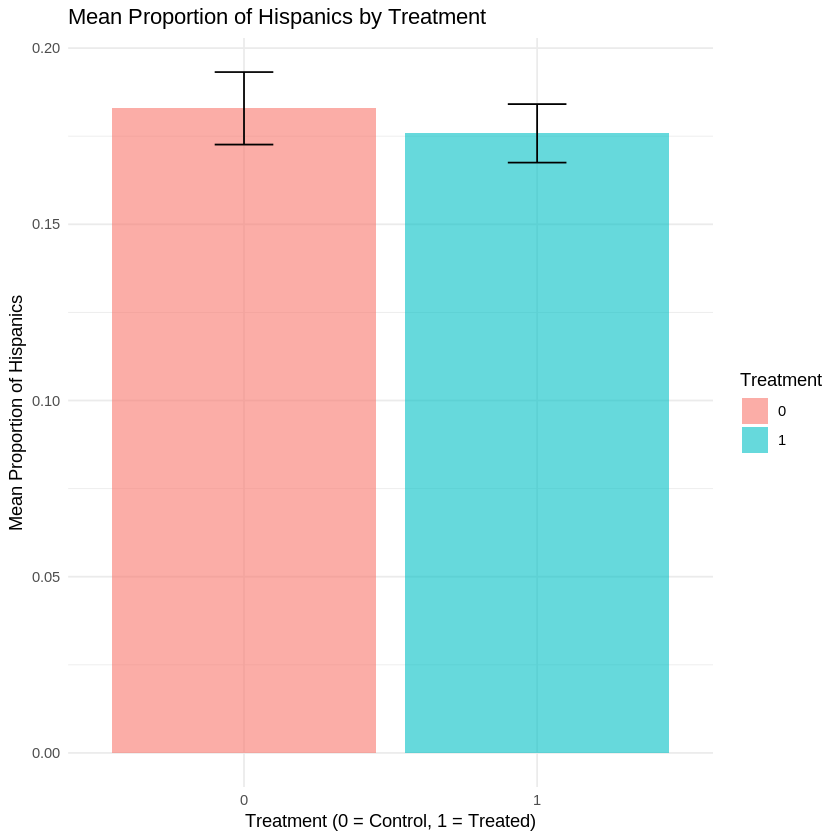

In [13]:
# Bar plot with confidence intervals
ggplot(treatment_means, aes(x = factor(treatmnt), y = mean_hispanic, fill = factor(treatmnt))) +
  geom_bar(stat = "identity", alpha = 0.6) +                          # Bar for mean
  geom_errorbar(aes(ymin = ci_lower, ymax = ci_upper), width = 0.2,   # Confidence intervals
                color = "black") +
  labs(
    title = "Mean Proportion of Hispanics by Treatment",
    x = "Treatment (0 = Control, 1 = Treated)",
    y = "Mean Proportion of Hispanics",
    fill = "Treatment"
  ) +
  theme_minimal()


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units


Warning message:
“Removed 3 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 3 rows containing non-finite outside the scale range
(`stat_summary()`).”


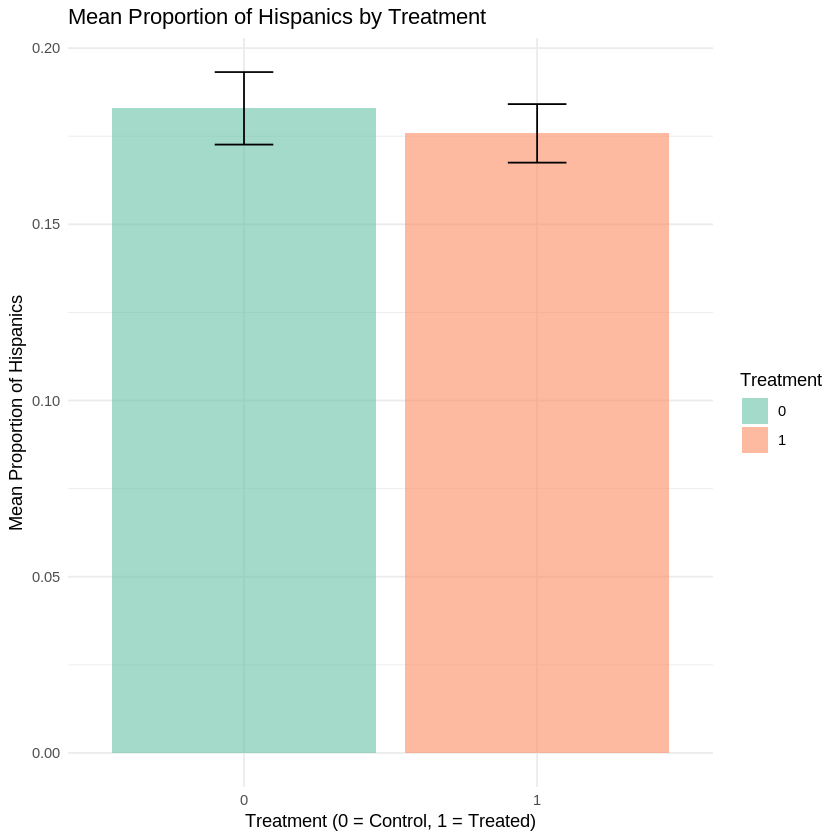

In [14]:
#install.packages('Hmisc')
library(Hmisc)

ggplot(JobCorps, aes(x = factor(treatmnt), y = hispanic, fill = factor(treatmnt))) +
  stat_summary(fun = mean, geom = "bar", alpha = 0.6) +
  stat_summary(
    fun.data = mean_cl_normal,                                         # 95% confidence intervals
    geom = "errorbar",
    width = 0.2
  ) +
  labs(
    title = "Mean Proportion of Hispanics by Treatment",
    x = "Treatment (0 = Control, 1 = Treated)",
    y = "Mean Proportion of Hispanics",
    fill = "Treatment"
  ) +
  scale_fill_brewer(palette = "Set2") +
  theme_minimal()

Difference in means test

In [15]:
mytest <- with( JobCorps, t.test(hispanic~treatmnt,alternative = c("two.sided"),conf.level = 0.95))
mytest


	Welch Two Sample t-test

data:  hispanic by treatmnt
t = 1.0527, df = 11519, p-value = 0.2925
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -0.006119742  0.020317268
sample estimates:
mean in group 0 mean in group 1 
      0.1829066       0.1758078 


In [16]:
t.test(JobCorps$hispanic~JobCorps$treatmnt,alternative = c("two.sided"),conf.level = 0.95)


	Welch Two Sample t-test

data:  JobCorps$hispanic by JobCorps$treatmnt
t = 1.0527, df = 11519, p-value = 0.2925
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -0.006119742  0.020317268
sample estimates:
mean in group 0 mean in group 1 
      0.1829066       0.1758078 


In [17]:
t.test(JobCorps$male~JobCorps$treatmnt,alternative = c("two.sided"),conf.level = 0.95)


	Welch Two Sample t-test

data:  JobCorps$male by JobCorps$treatmnt
t = 9.7337, df = 11944, p-value < 2.2e-16
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 0.06603005 0.09933011
sample estimates:
mean in group 0 mean in group 1 
      0.6519337       0.5692536 


conclusion is not possible to reject null hypothesis that hispanic in both groups are the same


use OLS model to see of randomization was sucessful

 first define vector of variables of interest

In [18]:
target.vars<-colnames(JobCorps)[19:36]
target.vars

[1] "white"              "black"              "hispanic"          
 [4] "eng_sec_language"   "havekids_at_bline"  "male"              
 [7] "educlevel_at_bline" "hsgrad_at_bline"    "ged_at_bline"      
[10] "everwork_at_bline"  "wrk_lyr_bline"      "mos_wrk_lyr_bline" 
[13] "earn_lyr_bline"     "wage_bline"         "anywlfr_bline"     
[16] "alcohol_bline"      "arrest_bline"       "jail_bline"

In [19]:
target.vars<-subset(colnames(JobCorps), grepl("earnq",colnames(JobCorps))==FALSE)
target.vars

[1] "treatmnt"           "dsgn_wgt"           "white"             
 [4] "black"              "hispanic"           "eng_sec_language"  
 [7] "havekids_at_bline"  "male"               "educlevel_at_bline"
[10] "hsgrad_at_bline"    "ged_at_bline"       "everwork_at_bline" 
[13] "wrk_lyr_bline"      "mos_wrk_lyr_bline"  "earn_lyr_bline"    
[16] "wage_bline"         "anywlfr_bline"      "alcohol_bline"     
[19] "arrest_bline"       "jail_bline"         "participate"       
[22] "voc_in_jc"          "work_wk48"          "pct_wks_wrk"       
[25] "logwage_wk208"      "wagenotmiss"        "attrit"            
[28] "nomiss"

In [20]:
summary(JobCorps[, target.vars])

    treatmnt        dsgn_wgt          white            black       
 Min.   :0.000   Min.   : 3.234   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.000   1st Qu.: 8.972   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :1.000   Median : 9.308   Median :0.0000   Median :0.0000  
 Mean   :0.598   Mean   :10.582   Mean   :0.2647   Mean   :0.4838  
 3rd Qu.:1.000   3rd Qu.:12.497   3rd Qu.:1.0000   3rd Qu.:1.0000  
 Max.   :1.000   Max.   :19.995   Max.   :1.0000   Max.   :1.0000  
                                  NA's   :3        NA's   :3       
    hispanic      eng_sec_language havekids_at_bline      male       
 Min.   :0.0000   Min.   :0.0000   Min.   :0.0000    Min.   :0.0000  
 1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.0000    1st Qu.:0.0000  
 Median :0.0000   Median :0.0000   Median :0.0000    Median :1.0000  
 Mean   :0.1787   Mean   :0.1427   Mean   :0.1912    Mean   :0.6025  
 3rd Qu.:0.0000   3rd Qu.:0.0000   3rd Qu.:0.0000    3rd Qu.:1.0000  
 Max.   :1.0000   Max.   :1.0000   M

In [21]:
cor_matrix <- cor(JobCorps[, c("white", "black", "hispanic", "treatmnt")], use = "complete.obs")
cor_matrix

,white,black,hispanic,treatmnt
white,1.000000000,-0.580834505,-0.279830911,0.004806219
black,-0.580834505,1.000000000,-0.451507564,0.002861297
hispanic,-0.279830911,-0.451507564,1.000000000,-0.009085827
treatmnt,0.004806219,0.002861297,-0.009085827,1.000000000


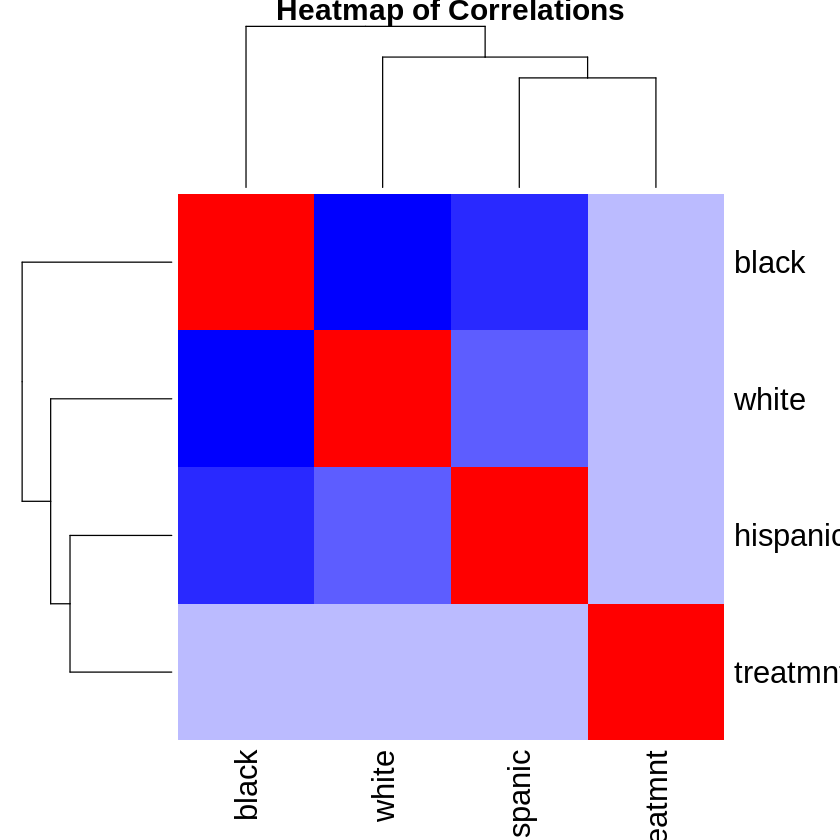

In [22]:
heatmap(cor_matrix, symm = TRUE, col = colorRampPalette(c("blue", "white", "red"))(50),
        main = "Heatmap of Correlations")

run the regression, first a simple example with 3 observable caracteristics


In [23]:
model1<-lm(treatmnt~ white+black+hispanic, data=JobCorps)
summary(model1)


Call:
lm(formula = treatmnt ~ white + black + hispanic, data = JobCorps)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6020 -0.5995  0.3980  0.4005  0.4115 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.597561   0.015632  38.228   <2e-16 ***
white        0.004397   0.017652   0.249    0.803    
black        0.001919   0.016767   0.114    0.909    
hispanic    -0.009082   0.018547  -0.490    0.624    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4903 on 13502 degrees of freedom
  (3 observations deleted due to missingness)
Multiple R-squared:  8.908e-05,	Adjusted R-squared:  -0.0001331 
F-statistic: 0.401 on 3 and 13502 DF,  p-value: 0.7523


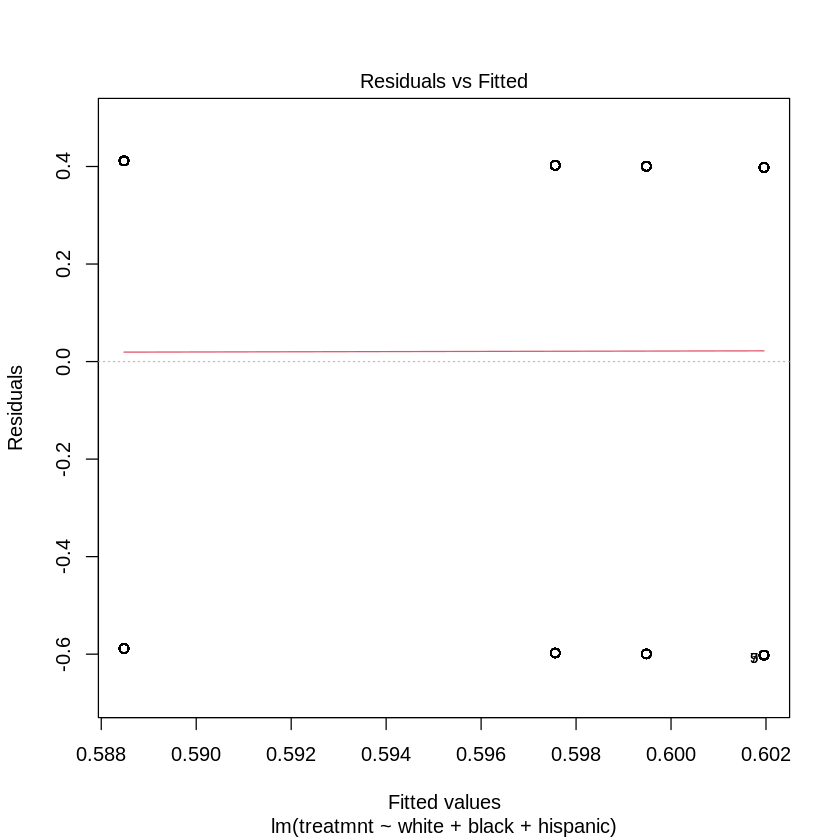

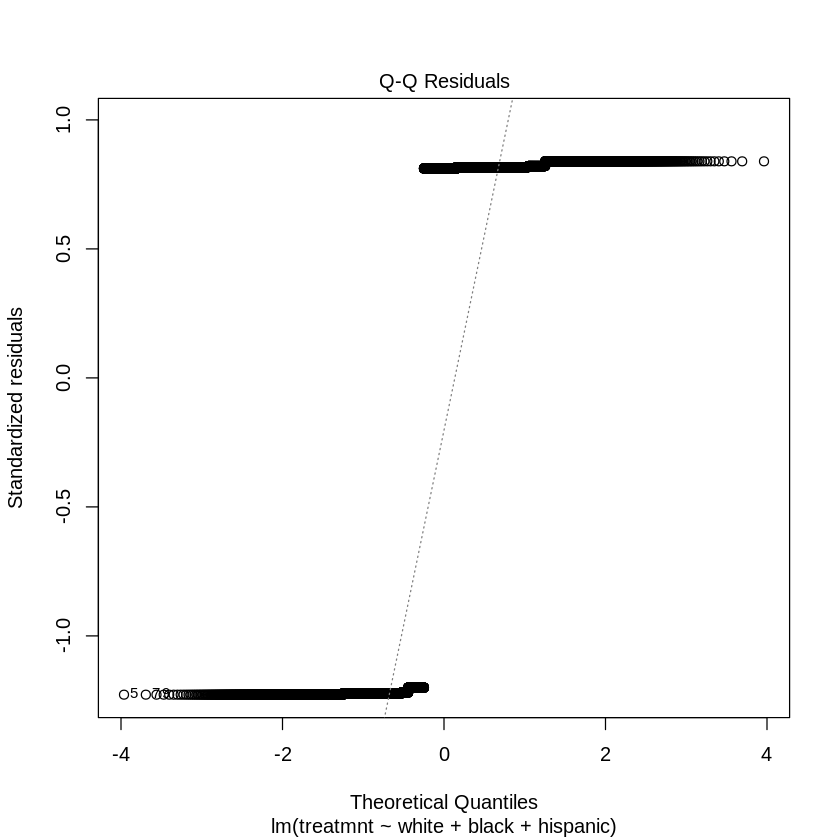

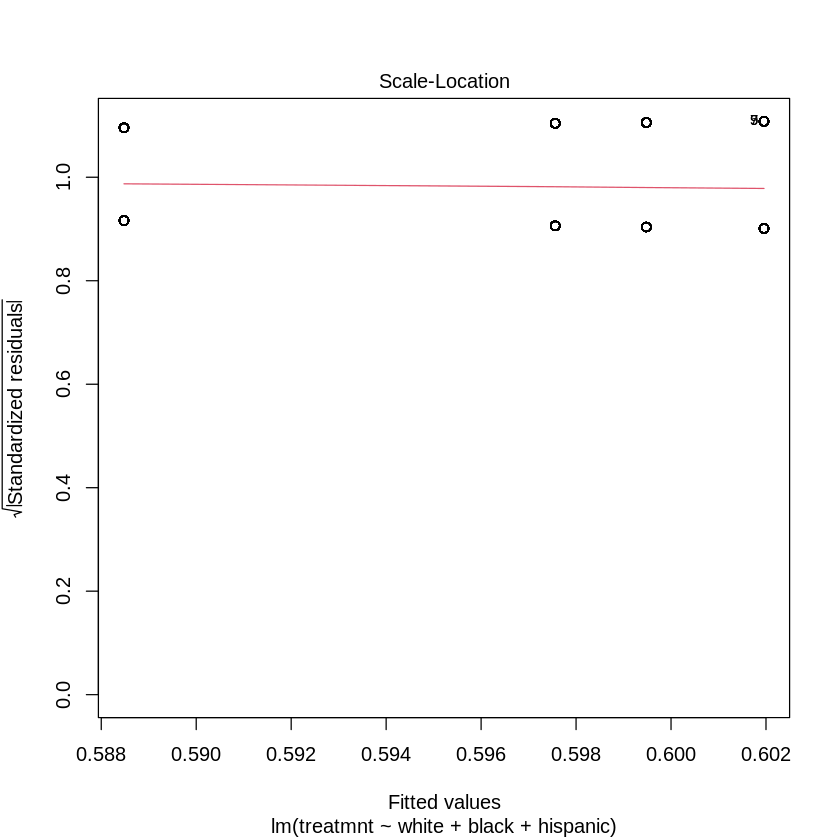

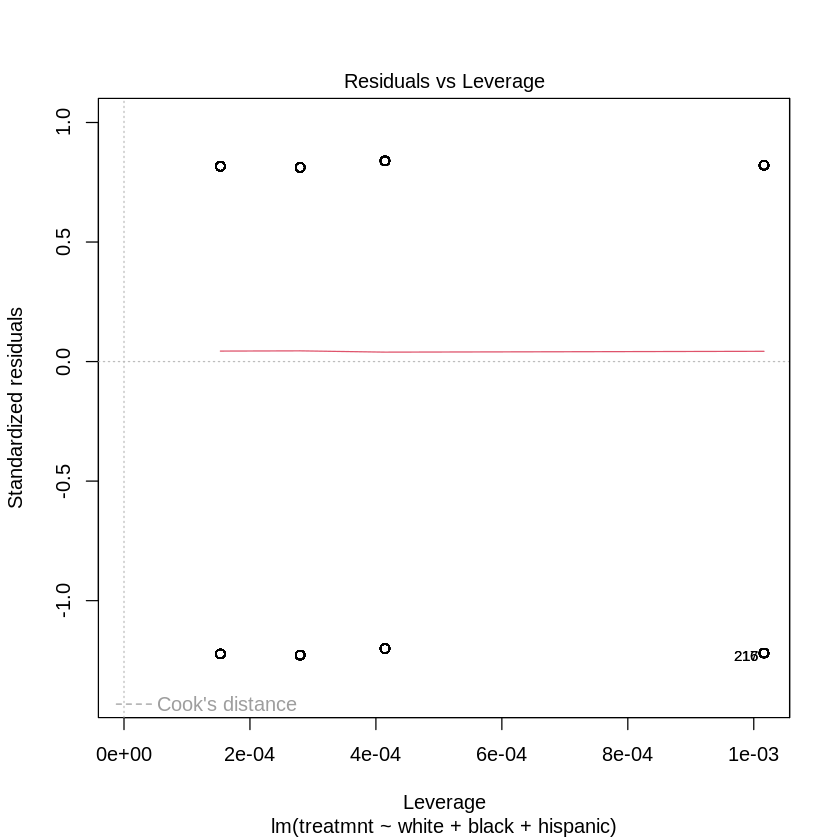

In [24]:
plot(model1)

 now all variables

  first save the model

In [25]:
formula.model2<-as.formula(paste("treatmnt","~",paste(target.vars,collapse="+"),sep=""))
formula.model2


treatmnt ~ treatmnt + dsgn_wgt + white + black + hispanic + eng_sec_language + 
    havekids_at_bline + male + educlevel_at_bline + hsgrad_at_bline + 
    ged_at_bline + everwork_at_bline + wrk_lyr_bline + mos_wrk_lyr_bline + 
    earn_lyr_bline + wage_bline + anywlfr_bline + alcohol_bline + 
    arrest_bline + jail_bline + participate + voc_in_jc + work_wk48 + 
    pct_wks_wrk + logwage_wk208 + wagenotmiss + attrit + nomiss

second run regression

In [26]:
model2<-lm(formula.model2,data=JobCorps)
summary(model2)

Warning message in model.matrix.default(mt, mf, contrasts):
“the response appeared on the right-hand side and was dropped”
Warning message in model.matrix.default(mt, mf, contrasts):
“problem with term 1 in model.matrix: no columns are assigned”



Call:
lm(formula = formula.model2, data = JobCorps)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.78200 -0.21119 -0.00504  0.15335  0.59647 

Coefficients: (4 not defined because of singularities)
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         1.415e+00  5.048e-02  28.038  < 2e-16 ***
dsgn_wgt           -8.592e-02  1.439e-03 -59.697  < 2e-16 ***
white               2.449e-03  1.833e-02   0.134   0.8937    
black              -3.710e-02  1.786e-02  -2.078   0.0378 *  
hispanic           -3.371e-02  1.850e-02  -1.822   0.0685 .  
eng_sec_language   -1.644e-02  1.502e-02  -1.095   0.2737    
havekids_at_bline  -6.115e-02  1.050e-02  -5.825 6.13e-09 ***
male               -1.452e-01  8.632e-03 -16.826  < 2e-16 ***
educlevel_at_bline  1.442e-03  3.557e-03   0.405   0.6852    
hsgrad_at_bline     5.565e-03  1.253e-02   0.444   0.6570    
ged_at_bline        1.359e-02  1.666e-02   0.816   0.4147    
everwork_at_bline          NA         NA   

selection on observables

In [27]:
formula.model3<-as.formula(paste("attrit","~",paste(target.vars,collapse="+"),sep=""))
formula.model3

attrit ~ treatmnt + dsgn_wgt + white + black + hispanic + eng_sec_language + 
    havekids_at_bline + male + educlevel_at_bline + hsgrad_at_bline + 
    ged_at_bline + everwork_at_bline + wrk_lyr_bline + mos_wrk_lyr_bline + 
    earn_lyr_bline + wage_bline + anywlfr_bline + alcohol_bline + 
    arrest_bline + jail_bline + participate + voc_in_jc + work_wk48 + 
    pct_wks_wrk + logwage_wk208 + wagenotmiss + attrit + nomiss

second run regression

In [28]:
model3<-lm(attrit~ white+black+hispanic, data=JobCorps)
summary(model3)


Call:
lm(formula = attrit ~ white + black + hispanic, data = JobCorps)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.2014 -0.1785 -0.1683 -0.1683  0.8317 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.194106   0.012211  15.896   <2e-16 ***
white       -0.015644   0.013789  -1.135   0.2566    
black       -0.025756   0.013098  -1.966   0.0493 *  
hispanic     0.007303   0.014488   0.504   0.6142    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.383 on 13502 degrees of freedom
  (3 observations deleted due to missingness)
Multiple R-squared:  0.001098,	Adjusted R-squared:  0.0008762 
F-statistic: 4.948 on 3 and 13502 DF,  p-value: 0.001962


In [29]:
model3<-lm(formula.model3, data=JobCorps)
summary(model3)

Warning message in model.matrix.default(mt, mf, contrasts):
“the response appeared on the right-hand side and was dropped”
Warning message in model.matrix.default(mt, mf, contrasts):
“problem with term 27 in model.matrix: no columns are assigned”



Call:
lm(formula = formula.model3, data = JobCorps)

Residuals:
   Min     1Q Median     3Q    Max 
     0      0      0      0      0 

Coefficients: (3 not defined because of singularities)
                   Estimate Std. Error t value Pr(>|t|)
(Intercept)               0          0     NaN      NaN
treatmnt                  0          0     NaN      NaN
dsgn_wgt                  0          0     NaN      NaN
white                     0          0     NaN      NaN
black                     0          0     NaN      NaN
hispanic                  0          0     NaN      NaN
eng_sec_language          0          0     NaN      NaN
havekids_at_bline         0          0     NaN      NaN
male                      0          0     NaN      NaN
educlevel_at_bline        0          0     NaN      NaN
hsgrad_at_bline           0          0     NaN      NaN
ged_at_bline              0          0     NaN      NaN
everwork_at_bline        NA         NA      NA       NA
wrk_lyr_bline          

In [30]:
test<-subset(JobCorps,complete.cases(JobCorps[,target.vars])==TRUE)

In [31]:
dim(test)

[1] 4292   44

In [32]:
cor(test[,target.vars])

Warning message in cor(test[, target.vars]):
“the standard deviation is zero”


,treatmnt,dsgn_wgt,white,black,hispanic,eng_sec_language,havekids_at_bline,male,educlevel_at_bline,hsgrad_at_bline,⋯,arrest_bline,jail_bline,participate,voc_in_jc,work_wk48,pct_wks_wrk,logwage_wk208,wagenotmiss,attrit,nomiss
treatmnt,1.000000000,-0.757855638,-0.001147542,0.004357659,-0.016517929,-0.010455481,0.0064991212,-0.071856194,0.008966061,0.021924815,⋯,-0.010420401,-0.004940782,0.695806678,0.636288814,0.039310680,-0.061421323,0.026101698,NA,NA,0.0176972953
dsgn_wgt,-0.757855638,1.000000000,0.051271491,-0.044101896,-0.006007524,-0.005157300,-0.0784865525,-0.094026666,-0.008222388,-0.008325490,⋯,-0.010731589,-0.016865559,-0.512269062,-0.456730241,-0.040632953,0.022302754,-0.038002363,NA,NA,-0.0209523059
white,-0.001147542,0.051271491,1.000000000,-0.615644825,-0.304754464,-0.235692147,-0.1620221605,0.121505646,-0.047786029,-0.003792042,⋯,0.073561508,0.050525786,-0.006578089,-0.008534460,0.058077403,0.125648012,0.074762260,NA,NA,-0.0112550655
black,0.004357659,-0.044101896,-0.615644825,1.000000000,-0.413325180,-0.292001552,0.1492585237,-0.115792084,0.064646633,0.021920075,⋯,-0.060132438,-0.044506338,-0.001221147,-0.006104552,-0.053009777,-0.103920880,-0.105433478,NA,NA,0.0043086886
hispanic,-0.016517929,-0.006007524,-0.304754464,-0.413325180,1.000000000,0.532580210,0.0376510565,-0.009811028,-0.013573093,-0.036263151,⋯,-0.010063940,-0.018459832,-0.006994468,0.003882747,0.016821482,0.001220669,0.029608041,NA,NA,0.0164376348
eng_sec_language,-0.010455481,-0.005157300,-0.235692147,-0.292001552,0.532580210,1.000000000,-0.0172100409,0.008348476,-0.006055973,0.006534088,⋯,-0.055744848,-0.040993656,0.003537922,0.012272666,0.035344238,0.009609917,0.025181188,NA,NA,0.0106822919
havekids_at_bline,0.006499121,-0.078486553,-0.162022161,0.149258524,0.037651057,-0.017210041,1.0000000000,-0.225615752,0.060045253,0.026873140,⋯,-0.017818839,0.018780767,-0.035414964,-0.044075877,-0.032162554,-0.018635172,-0.032386342,NA,NA,0.0253105308
male,-0.071856194,-0.094026666,0.121505646,-0.115792084,-0.009811028,0.008348476,-0.2256157520,1.000000000,-0.122951851,-0.143764906,⋯,0.157663911,0.104234007,0.003745627,-0.003203535,0.031367073,0.081746375,0.111733951,NA,NA,-0.0362582055
educlevel_at_bline,0.008966061,-0.008222388,-0.047786029,0.064646633,-0.013573093,-0.006055973,0.0600452530,-0.122951851,1.000000000,0.660831356,⋯,-0.148225402,-0.070539655,-0.042447851,-0.040807868,0.099969438,0.218409173,0.078221130,NA,NA,0.0559761365
hsgrad_at_bline,0.021924815,-0.008325490,-0.003792042,0.021920075,-0.036263151,0.006534088,0.0268731404,-0.143764906,0.660831356,1.000000000,⋯,-0.150530118,-0.057382457,-0.023781630,-0.019251139,0.093926418,0.208389520,0.053991627,NA,NA,0.0505056100


Average Treatment Effect  

In [33]:
formula.model_ATE<-as.formula(earnq16~treatmnt)
formula.model_ATE

earnq16 ~ treatmnt

In [34]:
model_ATE<-lm(formula.model_ATE,data=JobCorps, na.action = na.omit)
summary(model_ATE)


Call:
lm(formula = formula.model_ATE, data = JobCorps, na.action = na.omit)

Residuals:
    Min      1Q  Median      3Q     Max 
-214.46 -201.31  -21.74  117.71 2186.79 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  201.313      3.289   61.20  < 2e-16 ***
treatmnt      13.145      4.227    3.11  0.00188 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 213.6 on 10690 degrees of freedom
  (2817 observations deleted due to missingness)
Multiple R-squared:  0.0009038,	Adjusted R-squared:  0.0008104 
F-statistic: 9.671 on 1 and 10690 DF,  p-value: 0.001877


Is this a really ATE ?

Effect on the Treated

In [35]:
summary(subset(JobCorps,treatmnt==1)$earnq16)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    0.0     0.0   196.4   214.5   335.4  1970.4    1604 

In [36]:
ToT<-mean(subset(JobCorps,treatmnt==1)$earnq16,na.rm=TRUE)  # ToT: Average Effect of Treatment on the Treated
ToT

[1] 214.458

In [37]:
NT<-mean(subset(JobCorps,treatmnt==0)$earnq16,na.rm=TRUE)  # ToT: Average Effect of Treatment on the Treated
NT

[1] 201.3131

ATE , maybe

In [38]:
ToT-NT

[1] 13.14489

compare this to regression coefficient

In [39]:
 model_ATE$coefficients

(Intercept)    treatmnt 
  201.31308    13.14489

Randomization seems to be working

In [40]:
summary(model_ATE$residuals) #what is the expected value?

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-214.46 -201.31  -21.74    0.00  117.71 2186.79 

is this correlated with the treatment

In [41]:
cor(model_ATE$residuals,subset(JobCorps,complete.cases(JobCorps[,c("earnq16","treatmnt")])==TRUE)$treatmnt)

[1] 1.012149e-16

no correlation at all, what does this mean?